## Load traffic data



In [1]:
import urllib, json, objectpath
from pprint import pprint

In [2]:
def get_data(route):
    response = urllib.urlopen('http://pendlr.risc-software.at/log?id=["%s"]&num=10000' % route)
    data = json.loads(response.read())
    tree_obj = objectpath.Tree(data)
    return tuple(tree_obj.execute('$..entries'))
def get_route():
    response = urllib.urlopen('http://pendlr.risc-software.at/log?num=10000')
    data = json.loads(response.read())
    tree_obj = objectpath.Tree(data)
    return tuple(tree_obj.execute('$..id'))

The methods above will return json files with the relevent inforamtion, the routes names and the corresponding json.

Todo:
* Get the direction and see which route in close to another
* Merge the current traffic data with the weather data 
* make correlations between weather and traffic

In [3]:
routes = get_route()
cur_data   = {}

for r in routes :
    if 'cur.' in r:
        print "-- route : ", r
        cur_data[r] = get_data(r)

-- route :  cur.traun.b1.traffic.risc-software.at
-- route :  cur.zentrum.b129.traffic.risc-software.at
-- route :  cur.bindermichl.b1.traffic.risc-software.at
-- route :  cur.franzosenhausweg.knotenlinz.traffic.risc-software.at
-- route :  cur.einwaerts.bindermichl.traffic.risc-software.at
-- route :  cur.urfahr.b127.traffic.risc-software.at
-- route :  cur.einwaerts.haselgraben.traffic.risc-software.at
-- route :  cur.florianerstrasse.knotenlinz.traffic.risc-software.at
-- route :  cur.auswaerts.haselgraben.traffic.risc-software.at
-- route :  cur.linz.autobahnbruecke.traffic.risc-software.at
-- route :  cur.linz.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.zentrum.nibelungenbruecke.traffic.risc-software.at
-- route :  cur.rohrbach.b127.traffic.risc-software.at
-- route :  cur.urfahr.nibelungenbruecke.traffic.risc-software.at
-- route :  cur.wilhering.b129.traffic.risc-software.at
-- route :  cur.steyregg.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.urfahr

In [4]:
pprint(cur_data['cur.urfahr.b127.traffic.risc-software.at'  ][0])
pprint(cur_data['cur.rohrbach.b127.traffic.risc-software.at'][0])
pprint("---------------------")
pprint(cur_data['cur.wilhering.b129.traffic.risc-software.at' ][0])
pprint(cur_data['cur.zentrum.b129.traffic.risc-software.at'   ][0])

{u'data': {u'attrs': {u'average_speed': 57.6,
                      u'delay': 7,
                      u'delayed_average_speed': 54.0,
                      u'distance': [10002],
                      u'duration': [622],
                      u'duration_in_traffic': [629],
                      u'total_distance': 10002,
                      u'total_duration': 622,
                      u'total_duration_in_traffic': 629},
           u'nip': u'193.170.32.31',
           u'o_id': u'cur.urfahr.b127.traffic.risc-software.at'},
 u'latency': 172711,
 u'ts': 1486392600000}
{u'data': {u'attrs': {u'average_speed': 54.0,
                      u'delay': 82,
                      u'delayed_average_speed': 50.4,
                      u'distance': [9988],
                      u'duration': [625],
                      u'duration_in_traffic': [707],
                      u'total_distance': 9988,
                      u'total_duration': 625,
                      u'total_duration_in_traffic': 707},
  

From these output, we can see that that the usefull features would be the following:

```json
{u'attrs': {
      'average_speed'            : 39.6,
      'delay'                    : 8,
      'delayed_average_speed'    : 39.6,
      'total_distance'           : 4084,
      'total_duration'           : 359,
      'total_duration_in_traffic': 367
      }
}
```

For example the `total_duration` and `duration` are shown be on the same values. So one question rises, why `duration` here is a list and why it has the same value as the total one. 

In [5]:
import pandas as pd 
from pandas.io.json import json_normalize

In [6]:
cur_df = {}
for c in cur_data:
    print '-- route : ', c
    cur_df[c] = json_normalize(cur_data[c])

-- route :  cur.wilhering.b129.traffic.risc-software.at
-- route :  cur.zentrum.nibelungenbruecke.traffic.risc-software.at
-- route :  cur.haid.knotenlinz.traffic.risc-software.at
-- route :  cur.bindermichl.b1.traffic.risc-software.at
-- route :  cur.urfahr.autobahnbruecke.traffic.risc-software.at
-- route :  cur.florianerstrasse.knotenlinz.traffic.risc-software.at
-- route :  cur.urfahr.nibelungenbruecke.traffic.risc-software.at
-- route :  cur.urfahr.b127.traffic.risc-software.at
-- route :  cur.rohrbach.b127.traffic.risc-software.at
-- route :  cur.franzosenhausweg.knotenlinz.traffic.risc-software.at
-- route :  cur.zentrum.b129.traffic.risc-software.at
-- route :  cur.linz.autobahnbruecke.traffic.risc-software.at
-- route :  cur.linz.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.einwaerts.haselgraben.traffic.risc-software.at
-- route :  cur.einwaerts.bindermichl.traffic.risc-software.at
-- route :  cur.traun.b1.traffic.risc-software.at
-- route :  cur.auswaerts.haselg

After the normalisation of the json file, to make it easy to read, someone can use one root to extract the all the available features. But earlier we showed the most interetsing features so we are going to take those as the feature that we want to analyse

In [7]:
feat_traffic =  [
    'time',
    'data.attrs.delay'                    ,
    'data.attrs.average_speed'            ,
    'data.attrs.delayed_average_speed'    ,
    'data.attrs.total_distance'           ,
    'data.attrs.total_duration'           ,
    'data.attrs.total_duration_in_traffic'
]

### Running an example on just one route

let selection the `b129` root one of busiest route,

In [8]:
import numpy as np

df_routes = {}
for i,c in cur_df.items():
    _df_ = c
    _df_['time'] = pd.to_datetime(_df_['ts']/1000.0, unit='s')
    df_routes[i] = _df_[feat_traffic]

In [9]:
df_routes.keys()

[u'cur.wilhering.b129.traffic.risc-software.at',
 u'cur.zentrum.nibelungenbruecke.traffic.risc-software.at',
 u'cur.haid.knotenlinz.traffic.risc-software.at',
 u'cur.bindermichl.b1.traffic.risc-software.at',
 u'cur.urfahr.autobahnbruecke.traffic.risc-software.at',
 u'cur.florianerstrasse.knotenlinz.traffic.risc-software.at',
 u'cur.urfahr.nibelungenbruecke.traffic.risc-software.at',
 u'cur.urfahr.b127.traffic.risc-software.at',
 u'cur.rohrbach.b127.traffic.risc-software.at',
 u'cur.franzosenhausweg.knotenlinz.traffic.risc-software.at',
 u'cur.zentrum.b129.traffic.risc-software.at',
 u'cur.linz.autobahnbruecke.traffic.risc-software.at',
 u'cur.linz.steyreggerbruecke.traffic.risc-software.at',
 u'cur.einwaerts.haselgraben.traffic.risc-software.at',
 u'cur.einwaerts.bindermichl.traffic.risc-software.at',
 u'cur.traun.b1.traffic.risc-software.at',
 u'cur.auswaerts.haselgraben.traffic.risc-software.at',
 u'cur.steyregg.steyreggerbruecke.traffic.risc-software.at',
 u'cur.auswaerts.bindermich

In [10]:
import time
from dateutil import parser, rrule
from datetime import datetime, time, date

def uniformise_dataframe(data = pd.DataFrame()):
    print "shape :: ", data.shape
    data_copy = data
    data_copy.is_copy = False
    data_copy['minute'] = data_copy.time.apply(lambda x: datetime(x.year, x.month, x.day, x.hour, x.minute) )
    data_copy = data_copy.reset_index().groupby(['minute']).mean()
    data_copy.reset_index(inplace=True)
    data_copy = data_copy.set_index(data_copy.minute.values)
    data_copy = data_copy.drop('minute', 1)
    data_copy = data_copy.drop('index' , 1)
    return data_copy

In [11]:
for i in df_routes.keys():
    df_routes[i] = uniformise_dataframe(df_routes[i])
    print df_routes[i].shape

shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)
shape ::  (10000, 7)
(10000, 6)


Let combine the two dataframe for a single datset

Now let build some seasonal features such as :
* day of the year 
* hour in the day : we know that there is a reccurences during the day on the delay, for example when going for work
* day of the week : the delay should be different from weekend day then a working day

In [12]:
feat_time = ['day','dow','hod','working_day']

def fill_timefeatures(data = pd.DataFrame()):
    print "shape :: ", data.shape
    data_copy         = data
    data_copy.is_copy = False
    data_copy['day' ] = data.index.date
    data_copy['dow' ] = data.index.weekday   
    data_copy['hod' ] = data.index.hour
    # Is each time stamp on a working day (Mon-Fri)
    data_copy['working_day'] = (data_copy['dow'] >= 0) & (data_copy['dow'] <= 4)
    return data_copy

In [159]:
for i in df_routes.keys():
    df_routes[i] = fill_timefeatures(df_routes[i])
    df_routes[i].to_csv( i + '.csv')
    print df_routes[i].shape

shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)
shape ::  (10000, 10)
(10000, 10)


Let create a calendar vosualtion of the average delay

In [ ]:
import matplotlib.pyplot as plt
import calmap
import numpy  as np
import pandas as pd
from matplotlib import dates

%matplotlib inline
feature  =  ['data.attrs.delay'] 

for i,c in df_routes.items():
    for ft in feature:
        print ft ,' : ', i 
        dev_sr = pd.Series(c[ft].values, index=c.index)
        plt.figure(figsize=(14,5))
        calmap.yearplot(dev_sr, year=2017)
        plt.title(ft + ' : ' +  i )

In [ ]:
for i,c in df_routes.items():
    for feat in feature:
        print feat ,' : ', i 
        dev_sr = pd.Series(c[feat].values, index=c.index)
        plt.figure(figsize=(14,2))
        plt.plot(dev_sr)
        plt.title(feat + ' : ' +  i )

In [ ]:
for i,c in df_routes.items():
    for ft in feature:
        print feat ,' : ', i 
        dev_sr = pd.Series(c[ft].values, index=c.index)
        plt.figure(figsize=(14,2))
        plt.plot(dev_sr[len(dev_sr)-600:])
        plt.plot(dev_sr[len(dev_sr)-300:], c='red', label='used')
        plt.title(feat + ' : ' +  i )

## Forcasting using ARMA method :  ARMA (Autoregressive mouving average)

In [139]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

In [140]:
series = pd.Series(df_routes['cur.zentrum.b129.traffic.risc-software.at']['data.attrs.delay'].values, 
                   index = df_routes['cur.zentrum.b129.traffic.risc-software.at'].index,
                   dtype = np.dtype('float64')
                  )

In [141]:
one_day = 144
series

2017-02-06 14:50:00    304.0
2017-02-06 15:00:00      1.0
2017-02-06 15:10:00     14.0
2017-02-06 15:20:00     48.0
2017-02-06 15:30:00     83.0
2017-02-06 15:40:00    222.0
2017-02-06 15:50:00    142.0
2017-02-06 16:00:00    119.0
2017-02-06 16:10:00    148.0
2017-02-06 16:20:00    134.0
2017-02-06 16:30:00    103.0
2017-02-06 16:40:00     97.0
2017-02-06 16:50:00     69.0
2017-02-06 17:00:00     48.0
2017-02-06 17:10:00     33.0
2017-02-06 17:20:00      1.0
2017-02-06 17:30:00      2.0
2017-02-06 17:40:00      3.0
2017-02-06 17:50:00      0.0
2017-02-06 18:00:00      0.0
2017-02-06 18:10:00      0.0
2017-02-06 18:20:00      0.0
2017-02-06 18:30:00      0.0
2017-02-06 18:40:00      0.0
2017-02-06 18:50:00      0.0
2017-02-06 19:00:00      0.0
2017-02-06 19:10:00      0.0
2017-02-06 19:20:00      0.0
2017-02-06 19:30:00      0.0
2017-02-06 19:40:00      0.0
                       ...  
2017-04-18 03:40:00      0.0
2017-04-18 03:50:00      9.0
2017-04-18 04:00:00     12.0
2017-04-18 04:

In [142]:
type(series.values)


numpy.ndarray

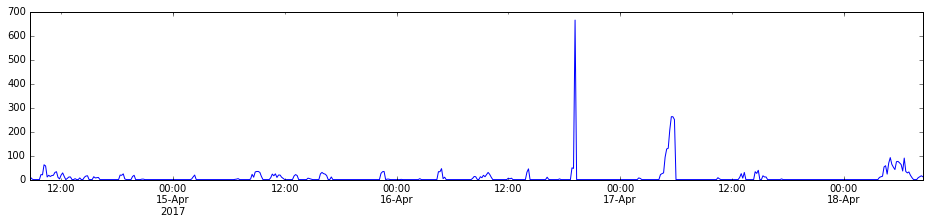

In [143]:
series[-4*one_day:].plot(figsize=(16,3));

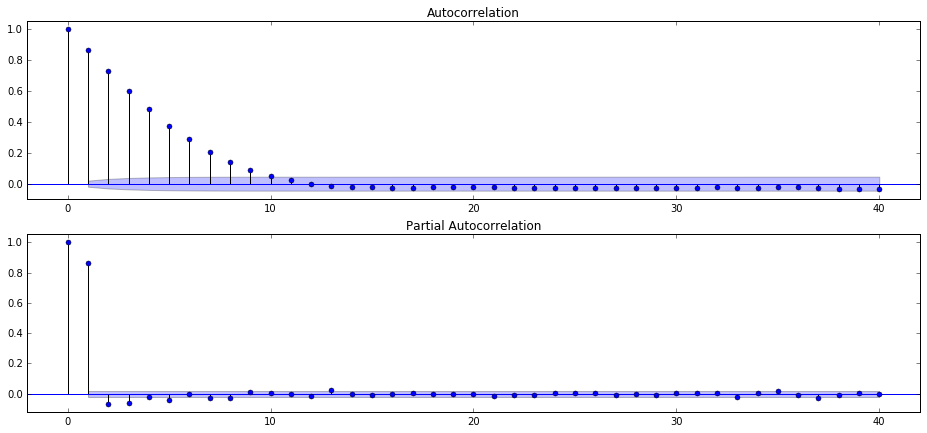

In [144]:
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, lags=40, ax=ax2)

In [145]:
arma_mod20 = sm.tsa.ARMA(series[-4*one_day:], (3,1)).fit()
print(arma_mod20.params)

const      8.895081
ar.L1.y    0.547620
ar.L2.y    0.108923
ar.L3.y   -0.011603
ma.L1.y   -0.227789
dtype: float64


In [146]:
arma_mod30 = sm.tsa.ARMA(series[-4*one_day:], (3,0)).fit()

In [147]:
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

(5689.900363194119, 5716.0370091582936, 5700.0933574377168)


In [148]:
print(arma_mod30.params)

const      8.895547
ar.L1.y    0.320158
ar.L2.y    0.183315
ar.L3.y    0.032143
dtype: float64


In [149]:
sm.stats.durbin_watson(arma_mod30.resid.values)

1.9994580012362533

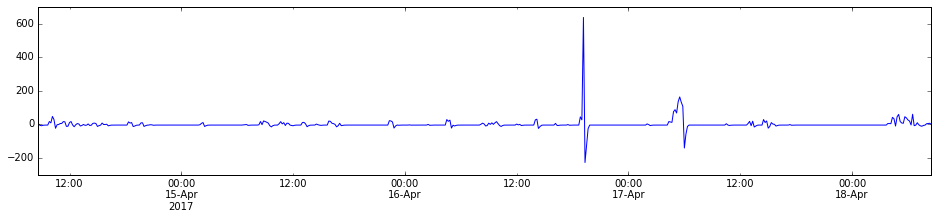

In [150]:
fig = plt.figure(figsize=(16,3))
ax = fig.add_subplot(111)
ax = arma_mod30.resid.plot(ax=ax);

In [151]:
resid = arma_mod30.resid
stats.normaltest(resid)

NormaltestResult(statistic=1063.4232587561035, pvalue=1.2038528280457249e-231)

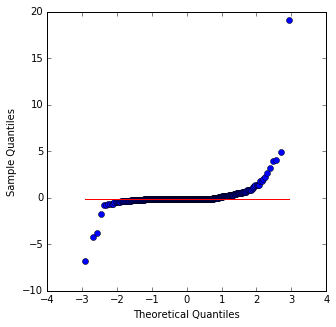

In [152]:
from statsmodels.graphics.api import qqplot

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

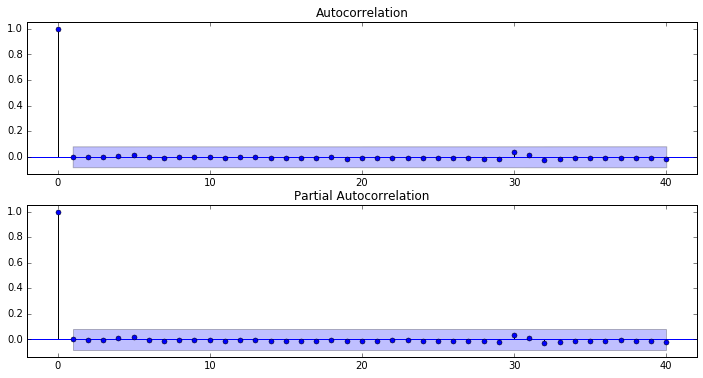

In [153]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [154]:
r,q,p = sm.tsa.acf(resid.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC         Q  Prob(>Q)
lag                               
1.0   0.000263  0.000040  0.994942
2.0  -0.001166  0.000829  0.999586
3.0  -0.003634  0.008502  0.999792
4.0   0.009781  0.064189  0.999496
5.0   0.017471  0.242165  0.998592
6.0  -0.004843  0.255862  0.999683
7.0  -0.013583  0.363818  0.999808
8.0  -0.005128  0.379230  0.999954
9.0  -0.001169  0.380033  0.999991
10.0 -0.005042  0.394985  0.999998
11.0 -0.009711  0.450552  0.999999
12.0 -0.003406  0.457398  1.000000
13.0 -0.005083  0.472674  1.000000
14.0 -0.010690  0.540377  1.000000
15.0 -0.009282  0.591509  1.000000
16.0 -0.008940  0.639025  1.000000
17.0 -0.010786  0.708311  1.000000
18.0 -0.000809  0.708702  1.000000
19.0 -0.013703  0.820935  1.000000
20.0 -0.011435  0.899231  1.000000
21.0 -0.009701  0.955687  1.000000
22.0 -0.007334  0.988012  1.000000
23.0 -0.007154  1.018823  1.000000
24.0 -0.010387  1.083889  1.000000
25.0 -0.008691  1.129532  1.000000
26.0 -0.008869  1.177149  1.000000
27.0 -0.012505  1.27

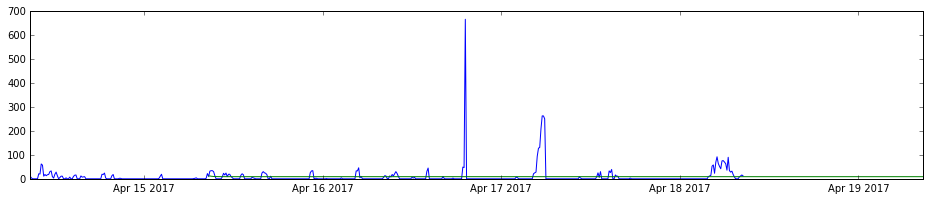

In [155]:
predict_sunspots = arma_mod30.predict(1*one_day,5*one_day, dynamic=True)

plt.figure(figsize=(16,3))
plt.plot(series[-4*one_day:])
plt.plot(predict_sunspots)

In [156]:
series.index[-144]

Timestamp('2017-04-17 08:40:00')

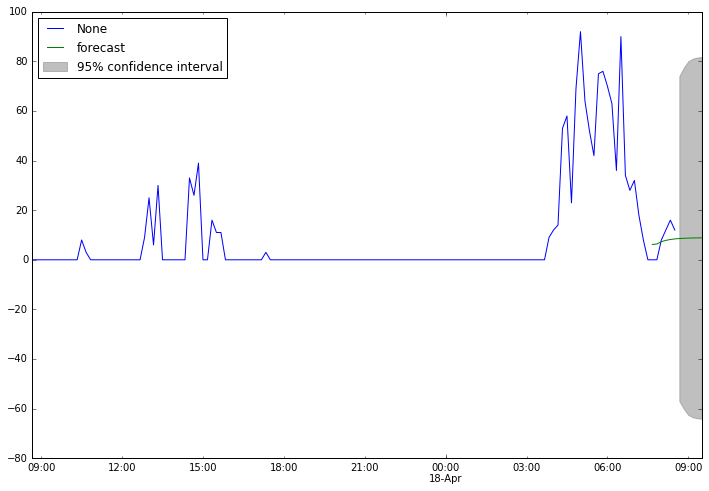

In [157]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = series[-one_day:].plot(ax=ax)
fig = arma_mod30.plot_predict(series.index[-6],series.index[-1] + np.timedelta64(1, 'h'), dynamic=True, ax=ax, plot_insample=False)

### New method

In [158]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)


for i,c in df_routes.items():
    for ft in feature:
        print feat ,' : ', i 
        serie = pd.Series(c[ft].values, index=c.index)
        plt.figure(figsize=(14,2))
        plt.title(feat + ' : ' +  i )
        
        X = serie[len(dev_sr)-600:].values
        X = X.astype('float32')
        # difference data
        hours_in_day = 12
        stationary = difference(X, hours_in_day)
        stationary.index = serie[len(dev_sr)-600:].index[hours_in_day:]

        # check if stationary
        result = adfuller(stationary)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        stationary.plot()
        plt.show()

NameError: name 'feature' is not defined

In [ ]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [ ]:
# from pandas import Series
# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.graphics.tsaplots import plot_pacf

# series_sta = Series.from_csv('stationary.csv')

# plt.figure(figsize=(9,4))
# plt.subplot(211)
# plot_acf(series_sta, ax=plt.gca(), lags=144)
# plt.subplot(212)
# plot_pacf(series_sta, ax=plt.gca(), lags=144)
# plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [ ]:
for i,c in df_routes.items():
    for feat in feature:
        print feat ,' : ', i 
        serie = pd.Series(c[feat].values, index=c.index)
        plt.figure(figsize=(14,2))
        plt.title(feat + ' : ' +  i )
        # prepare data
        X = serie[len(dev_sr)-600:].values
        X = X.astype('float32')
        train_size  = int(len(X) * 0.50)
        train, test = X[0:train_size], X[train_size:]
        # walk-forward validation
        history     = [x for x in train]
        predictions = list()
        for i in range(len(test)):
            # difference data
            months_in_year = 12
            diff = difference(history, months_in_year)
            # predict
            model     = ARIMA(diff, order=(1,1,1))
            model_fit = model.fit(trend='nc', disp=0)
            yhat      = model_fit.forecast()[0]
            yhat      = inverse_difference(history, yhat, months_in_year)
            predictions.append(yhat)
            obs = test[i]
            history.append(obs)
        #     print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
        # report performance
        mse  = mean_squared_error(test, predictions)
        rmse = sqrt(mse)
        print('RMSE: %.3f' % rmse)
        plt.plot(test, label='test')
        plt.plot(np.abs(predictions), label='prediction')
        plt.legend()
        plt.show()

In [ ]:
plt.figure(figsize=(12,3))
plt.plot(test, label='test')
plt.plot(np.abs(predictions), label='prediction')

plt.legend()

mse  = mean_squared_error(test, np.abs(predictions) )
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

In [ ]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
serie = serie['2017-03-13':'2017-03-26']    
# evaluate parameters
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(serie.values, p_values, d_values, q_values)

In [ ]:
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model     = ARIMA(diff, order=(1,0,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat      = model_fit.forecast()[0]
    yhat      = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

In [ ]:
plt.figure(figsize=(12,3))
plt.plot(test, label='test')
plt.plot(np.abs(predictions), label='prediction')

plt.legend()

In [ ]:
[cur.linz.autobahnbruecke.traffic.risc-software.at]
id = 'cur.linz.autobahnbruecke.traffic.risc-software.at'
ip_address = '193.170.32.6'
query = 'http://pendlr.risc-software.at/log?id=["cur.linz.autobahnbruecke.traffic.risc-software.at"]'
builder = 'node_builder'
clazz = 'URLJsonCollector'
parser='jsonparser'
stream = 'store_stream'
time_normalized = True
sleep_seconds = 600 # this is for the thread
sleep_offset = 2
processor = 'traffic_distance_processor'
log_type = 'urljson'
normalized = True
interval = 600 # modular division of the timestamp to use